In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt 
import torch
from jac_hess import jacobian, hessian 

 

Lagrangian for spring pendulum, in 2D, with $r$ spring length, $\theta$ angle from vertical: 

$\mathcal{L} = T - V = \frac{1}{2}\dot{r}^2 + \frac{1}{2} r^2\dot{\theta}^2 - gr(1-\cos(\theta)) - k(r -r_0)^2$

By applying Euler Lagrange equataions get:

$\ddot r = r\dot{\theta}^2 + g(1-\cos(\theta)) - 2k(r-r_0)$

and 

$\ddot \theta = -\frac{1}{r}(g\sin(\theta) + 2\dot{r}\dot{\theta})$

can use these and `odeint` to solve analytically.



In [147]:
def lagrangian(q, qt, g=10, k=10):
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-torch.cos(q[1])) + k*(q[0] - 1)**2
    return T - V 


In [148]:
def get_qdtt(q, qt, g=10, k=10):
    '''
    q is array of genralise coords, [r, theta]
    qt is array of genralise coords, [rdt, thetadt]

    returns time derivative of q.
    '''
    qdtt = np.zeros_like(q)

    qdtt[0] = q[0]*qt[1]**2 + g*(1-np.cos(q[1])) - 2*k*(q[0]-1) 
    qdtt[1] = -(g*np.sin(q[1]) -2*qt[0]*qt[1])/q[0]

    return qdtt  

def anal_solve_ode(q0, qt0, t,):

    x0 = np.append(q0, qt0)

    def f(x, t):
        d = np.zeros_like(x)
        d[:2] = x[2:]
        d[2:] = get_qdtt(x[:2], x[2:])

        # print(x, d)
        return d
    
    return odeint(f, x0, t, rtol=1e-10, atol=1e-10)
    
def q2xy(ql):
    '''
    Polar coords to xy
    '''

    xy = np.zeros_like(ql)

    xy[:, 0] = ql[:, 0]*np.sin(ql[:, 1])
    xy[:, 1] = -ql[:, 0]*np.cos(ql[:, 1])

    return xy  


In [157]:
t = np.arange(0, 4, 0.05)

q0 = np.array([1.01, 0.1])
qt0 = np.array([0, 0])

path = anal_solve_ode(q0, qt0, t)
xy = q2xy(path)

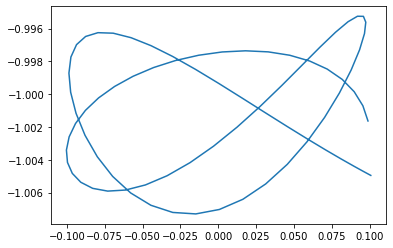

In [158]:
plt.plot(xy[:, 0], xy[:, 1])
plt.show()

We can also solve using pytorch to autodiff the lagrangian, an use the following version of the EL equations (after Cranmer et al.), with $q=(r, \theta)$:

$\ddot q = (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q]$





In [161]:
def get_tqtt(lagrangian, tq, tqt):
    
    L = lagrangian(tq, tqt)

    A = torch.inverse(hessian(L, tqt))
    B = jacobian(L, tq)
    C = jacobian(jacobian(L, tqt, create_graph=True), tq)

    return A @ (B - C @ tqt)

def torch_solve_ode(q0, qt0, t, lagrangian):
    
    x0 = np.append(q0, qt0)

    def f(x, t):
        tq = torch.tensor(x[:2], requires_grad=True)
        tqt = torch.tensor(x[2:], requires_grad=True)

        tqtt = get_tqtt(lagrangian, tq, tqt)

        qt = tqt.detach().numpy()
        qtt = tqtt.detach().numpy()
        
        xt = np.append(qt, qtt)
        # print(x, xt)
        return xt 
        
    return odeint(f, x0, t, rtol=1e-10, atol=1e-10)

In [162]:
tpath = torch_solve_ode(q0, qt0, t, lagrangian)
txy = q2xy(tpath)


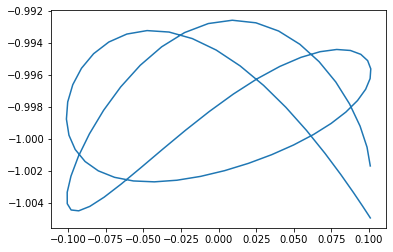

In [164]:

plt.plot(txy[:, 0], txy[:, 1])


MSE From pytorch

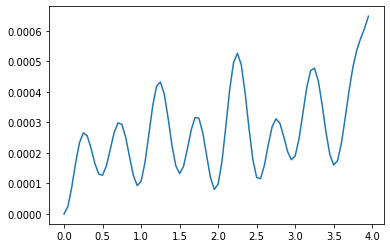

In [166]:
plt.plot(t, np.sum((tpath - path)**2, axis=1))